## Local Import

* working localy trim the data to ensure you can work with it locally <br\>*(my computer does not have sufficient local memory to join all tables so I use appropriate attributes)*

attempted stratagy (merge pd_df until memory bound then print to file)

In [1]:
import json, csv, os
import pandas as pd


def JSON_to_dataFrame(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() ] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df


In [2]:
root_path = "/Users/2015mbp16gb256gb/Documents/school/Fall_2019/4502-Data_Mining/Group_Project/Group1/yelp_dataset/"
rbu_path = root_path + "rbu_merge.json"
filtered_merge_path = root_path + "filtered_merge.json"

## Reviewing Business File

In [ ]:
import sys
try: 
    !{sys.executable} -m pip install plotly --upgrade
    !{sys.executable} -m pip install geopandas==0.3.0
    !{sys.executable} -m pip install pyshp==1.2.10
    !{sys.executable} -m pip install shapely==1.6.3
    !{sys.executable} -m pip install "notebook>=5.3" "ipywidgets>=7.2"
    !{sys.executable} -m pip install chart_studio
    !{sys.executable} -m pip install plotly-geo
    !{sys.executable} -m pip install folium
except: 
    print("already installed")

In [3]:
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

# clustering imports
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# plotly imports 
import plotly
from plotly import __version__
print('running plotly = {}'.format(__version__))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.graph_objects as go

from sklearn.decomposition import PCA 

running plotly = 4.2.1


In [4]:
init_notebook_mode(connected=True)

In [5]:
%%time

business_df = JSON_to_dataFrame(root_path + "business.json")
business_df['text'] = business_df['state'] + ', ' + business_df['city']

CPU times: user 4.04 s, sys: 362 ms, total: 4.4 s
Wall time: 4.44 s


### Reviewing The Buiness Data

In [35]:
# find the amount of states in the dataset
business_df.groupby('state').state.count()

state
AB      8012
AK         2
AL         3
AR         1
AZ     56686
BAS        1
BC         1
CA        19
CON        1
CT         3
DOW        1
DUR        1
FL         4
GA         2
IL      1932
NC     14720
NE         2
NJ         1
NM         1
NV     36312
NY        22
OH     14697
ON     33412
PA     11216
QC      9219
SC      1162
TN         1
TX         6
UT         1
VA         2
VT         2
WA         3
WI      5154
XGL        1
XGM        4
XWY        2
Name: state, dtype: int64

* since the majority of the data is found in 11 States lets cluster to see how dence the data is

### Kmeans Attempt

* Kmeans can be sensative to outliers but most of the information is naturally clumped so we dont have to worry 

In [36]:
# transform the data 

coordinates_df = business_df[['longitude','latitude']].copy()

pca = PCA(n_components=2)
coordinates = pca.fit_transform(coordinates_df)

*using the elbow method to find k*

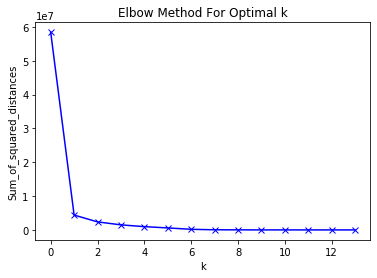

In [38]:
Sum_of_squared_distances = []
K = 15

for k in range(1, K):
    km = KMeans(n_clusters=k)
    km = km.fit(coordinates)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

*We will still try 11 to see how the data splits up*

In [71]:
#Train model
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters).fit(coordinates)

In [65]:
business_df['labels'] = pd.DataFrame(kmeans.labels_)

*Lets see what states connecto to clusters*

In [66]:
groupby_lables = business_df.groupby('labels').agg(lambda x:x.value_counts().index[0])

In [79]:
state_lables = list(groupby_lables['state'])

In [68]:
# let's plot cluster information for nationwide visualization

import plotly.graph_objects as go
'''
fig = go.Figure(data=go.Scattergeo(
        lon = business_df['longitude'],
        lat = business_df['latitude'],
        text = business_df['text'],
        mode = 'markers',
        marker_color = business_df['lables'],
        ))

fig.update_layout(
        title = 'US Cluster<br>(hover for spicific informaiton)',
        geo_scope='usa',
    )
fig.show()
'''

"\nfig = go.Figure(data=go.Scattergeo(\n        lon = business_df['longitude'],\n        lat = business_df['latitude'],\n        text = business_df['text'],\n        mode = 'markers',\n        marker_color = business_df['lables'],\n        ))\n\nfig.update_layout(\n        title = 'US Cluster<br>(hover for spicific informaiton)',\n        geo_scope='usa',\n    )\nfig.show()\n"

![img](map.png)

#### Lets investigate the review count and start of each of the clusters 

In [93]:
national_review_mean = business_df["review_count"].mean()
national_stars_mean = business_df["stars"].mean()
print("national_stars_mean = ", national_stars_mean)
print("national_review_mean = ", national_review_mean)

national_stars_mean =  3.585626839867296
national_review_mean =  33.53896235378409


In [110]:
def sortSecond(val): 
    return val[1] 

review_count = []
rating_stars = []
ratio_open_close = []
count = []
for n in range(n_clusters):
    indexes = business_df[business_df["labels"] != n].index
    temp = business_df.copy()
    temp.drop(indexes, inplace=True)
    rating_stars.append((n, temp["stars"].mean()))
    review_count.append((n, temp["review_count"].mean()))
    count.append((n, temp.count()))
    ratio_open_close.append((n, 1 - temp["is_open"].sum() / temp["is_open"].count() ))

print("Star's mean per cluster = ")
rating_stars.sort(key = sortSecond, reverse = True)
for i, value in rating_stars: 
    print(state_lables[i], value)
    
review_count.sort(key = sortSecond, reverse = True)
print("\nReview_count's mean per cluster = ")
for i, value in review_count: 
    print(state_lables[i], value) 
    
ratio_open_close.sort(key = sortSecond)    
print("\nRatio of closed businesses per cluster = ")
for i, value in ratio_open_close: 
    print(state_lables[i], "=", value) 
    
print("\nCount per cluster = ")
for i, value in count: 
    print("--"+state_lables[i]+"--",value)

Star's mean per cluster = 
AZ 3.7578270684071056
NV 3.696218730219886
AZ 3.6479632816982215
QC 3.634898312418866
WI 3.610895696006204
PA 3.577598502406846
NC 3.539541619443395
OH 3.505374880936182
IL 3.4647850854479545
AB 3.3856143856143857
ON 3.3563926872325784

Review_count's mean per cluster = 
NV 61.79425929493354
AZ 37.28854647168515
AZ 33.03576209600306
NC 26.116861856189395
WI 25.130283055447848
PA 25.06141914779818
ON 22.77672720744442
IL 21.219057483169344
OH 21.129133215403456
QC 19.03147987884033
AB 12.08066933066933

Ratio of closed businesses per cluster = 
OH = 0.14648251462784057
NC = 0.15627754690844986
PA = 0.15920841504724548
AZ = 0.16140753490151083
AB = 0.16458541458541454
QC = 0.17265253137170056
AZ = 0.18183007818889652
WI = 0.18301667312911984
NV = 0.1858436304593114
IL = 0.20041429311237702
ON = 0.20606804105203314

Count per cluster = 
--AZ-- business_id     30567
name            30567
address         30567
city            30567
state           30567
postal_cod

*********
### Merging Files
* merge review, business, and user. Clean format to ensure no merge conflicts

In [ ]:
%%time

review_df = JSON_to_dataFrame(root_path + "review.json")
business_df = JSON_to_dataFrame(root_path + "business.json")
user_df = JSON_to_dataFrame(root_path + "user.json")
# tip_df = JSON_to_dataFrame(root_path + "tip.json")                     /not used
# checkin_df = JSON_to_dataFrame(root_path + "checkin.json")             /not used

In [ ]:
# utility function to make a dict of columns with table name added
# used for the renaming of column names
def make_columns(lst, base):
    ret = {}
    for i in lst:
        ret[i] = base + '_' + i
    return ret

In [ ]:
# return dataframe with column names updated to "table + _column_name"
def process_df(a_df, table): 

    col_list = [i for i in a_df]
    new_dict = make_columns(col_list, table)
    return a_df.rename(columns=new_dict)

In [ ]:
%%time

# review col = ['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

# ***Update review_df*** 
review_drop = ['cool','funny']
review_df = review_df.drop(review_drop, axis=1)

review_df = process_df(review_df, 'review')

In [ ]:
%%time

# business col = 
# ['address','attributes','business_id','categories','city','hours','is_open',              
# 'latitude','longitude','name','postal_code','review_count','stars','state']                              

# ***Update business_df***
business_drop = ['address', 'attributes', 'categories','city', 'postal_code']
business_df = business_df.drop(business_drop, axis=1)

business_df = process_df(business_df, 'business')

In [ ]:
%%time

rb_merge = pd.merge(review_df, business_df, left_on='review_business_id', right_on='business_business_id', how='inner')

In [ ]:
%%time

# user col = 
# ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list',           
# 'compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer', 
# 'cool','elite','fans','friends','funny','name','review_count','useful','user_id','yelping_since']   

# ***Update _user_df***
user_drop = ['average_stars','compliment_cool','compliment_cute','compliment_funny','compliment_hot','compliment_list','compliment_more','compliment_note','compliment_photos','compliment_plain','compliment_profile','compliment_writer','cool', 'elite', 'fans','friends','funny']
user_df = user_df.drop(user_drop, axis=1)

user_df = process_df(user_df, 'user')

In [ ]:
%%time

rbu_merge = pd.merge(rb_merge, user_df, left_on='review_user_id', right_on='user_user_id', how='inner')

In [ ]:
%%time

rbu_drop = ['review_business_id','review_user_id', 'business_hours']
rbu_merge = rbu_merge.drop(rbu_drop, axis=1)


## Filter Data to prepare for converstion back to json
* (Drop all states that are not AZ)

In [ ]:
rbu_merge.shape

In [ ]:
filtered_merge = rbu_merge[rbu_merge['business_state'] == 'AZ'].copy()

In [ ]:
filtered_merge.shape

*********
### Writing Merged DataFrame Back To Json

In [ ]:
def df_to_json(df, path):
    new_dict = {}
    num_col = len([i for i in df])

    with open(r'{}'.format(path), 'w') as writer: 

        for row in df.itertuples():
            
            for idx, col in enumerate(df): 
                if type(row[idx+1]) == int: 
                    new_dict[col] = int(row[idx+1])
                if type(row[idx+1]) == float: 
                    new_dict[col] = float(row[idx+1])
                else: 
                    new_dict[col] = str(row[idx+1])
                
            writer.write(json.dumps(new_dict) + '\n')
            new_dict = {}         



In [ ]:
%%time

df_to_json(filtered_merge, filtered_merge_path)

****
### Open "filtered_merge" file for further processing

In [10]:
%%time

review_df = JSON_to_dataFrame(filtered_merge_path)

CPU times: user 39.4 s, sys: 6.66 s, total: 46.1 s
Wall time: 45.7 s


### Take a look at the clustered AZ informaiton

In [11]:
def make_unique(df, col1, col2): 
    unique = []
    booliens = []

    for (x,y) in zip(df[col1], df[col2]):
        if (x,y) not in unique:
            booliens.append(True)
            unique.append((x,y))
        else:
            booliens.append(False)

    return booliens

In [12]:
booliens = []

arg1 = 'business_longitude'
arg2 = 'business_latitude'
booliens = make_unique(review_df, arg1, arg2)

In [13]:
booliens[:5]

[True, True, True, True, True]

In [14]:
unique_values = pd.Series(booliens)

In [15]:
unique_review_df = review_df[unique_values]

In [149]:
# transform the data 
max_unique1 = unique_review_df[unique_review_df['business_is_open'] == '0'].copy()
max_unique = max_unique1[max_unique1['business_stars'] <= 2.5].copy()

coordinates_df = max_unique[['business_longitude','business_latitude']].copy()

pca = PCA(n_components=2)
coordinates = pca.fit_transform(coordinates_df)

In [ ]:
# use the elbow method to find k
Sum_of_squared_distances = []
K = 15

for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit(coordinates)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
print(len(Sum_of_squared_distances))

In [ ]:
plt.plot(Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [150]:
#Train model
kmeans = KMeans(n_clusters=3).fit(coordinates)

In [18]:
unique_review_df = pd.DataFrame(unique_review_df)

In [152]:
max_unique['lables'] = pd.DataFrame(kmeans.labels_)

In [160]:
max_unique

review_review_id  review_stars review_useful  \
5        7wyuK194Zjyoy0vhDvOjGw           3.0             5   
142      npThCBQYv__bV08PlHzknQ           3.0             8   
208      IUZmjI_Mx9kBeW5iyvS06g           4.0             3   
213      l4jQlakHPHszkdIXXeeaYg           4.0             4   
221      4QMgZM_K0tx1FLQJrtMXtA           3.0             2   
...                         ...           ...           ...   
1986844  G4J4enDxPwYF0fY4qFuW3A           1.0             1   
1986908  RRjxBdqhd0_IiCSE-D9uFw           4.0             2   
1992307  c0Ml8joOYqkQTPtLutI6Bw           4.0             0   
2035235  rC37ZYZdvNsOX77GKxxPYQ           1.0             7   
2067058  R59xMVVceRbkrE3eW7WBxA           1.0             9   

                                               review_text  \
5        I was not planning on coming here but my frien...   
142      Was getting my car washed next door and wanted...   
208      Located in the very popular Tempe Marketplace,...   
213      I just became a member here and workout at two...   
221      One of my 'go to' spots for a quick lunch.  Mo...   
...                                                    ...   
1986844  Placed an order on January 26, 2014. Received ...   
1986908  I have never resigned at an apartment complex ...   
1992307  Read your contract. My lifetime is a what I si...   
2035235  I ordered  6 of an   item that was advertised ...   
2067058  HORRIBLE EXPERIENCE... EXTREMELY UNPROFESSIONA...   

                 review_date    business_business_id  \
5        2014-04-07 22:02:31  f6mQYyU_ga0DVRuRZhkmfQ   
142      2011-06-10 14:55:33  z8Em-bhZI3Mmspml7tj6tg   
208      2013-03-19 13:55:11  WEoivlVObGE03PiWvVvXYA   
213      2013-03-08 13:56:47  fercXJpucosaQr-1NdlSSg   
221      2013-01-19 12:54:41  yJLxYFLB0W94yvDsVL2sbg   
...                      ...                     ...   
1986844  2015-02-03 19:03:33  RiHMAqbJRqJ-Yeso1H8doQ   
1986908  2013-01-28 21:19:03  MwIe6m4s1KKbvUM79gHGNA   
1992307  2015-05-04 14:20:53  xLgQg3IVuj8XoBuxU0uT9A   
2035235  2013-01-08 00:44:52  VRWUZddjHwK5XDeIGc7mMA   
2067058  2009-10-13 21:13:26  g_W9HM5KgCxeeralD-rzjQ   

                           business_name business_state  business_latitude  \
5                         Margaritaville             AZ          33.533773   
142                Dickey's Barbecue Pit             AZ          33.581501   
208                       Cadillac Ranch             AZ          33.433211   
213                           Gold's Gym             AZ          33.620211   
221                      Jack-In-the Box             AZ          33.495272   
...                                  ...            ...                ...   
1986844             Pro Gold Prospecting             AZ          33.594954   
1986908         Centrado Apartment Homes             AZ          33.406600   
1992307  Jenny Craig Weight Loss Centres             AZ          33.517258   
2035235                  Allegro Medical             AZ          33.450430   
2067058                 Hunter III Homes             AZ          33.447485   

         business_longitude  business_stars business_review_count  \
5               -112.261718             2.5                   178   
142             -111.923393             2.5                    96   
208             -111.903337             2.5                   175   
213             -111.896269             2.5                    75   
221             -111.907954             2.5                    29   
...                     ...             ...                   ...   
1986844         -112.299602             1.0                     3   
1986908         -111.899255             2.0                     3   
1992307         -112.065010             2.0                     3   
2035235         -111.911381             1.0                     5   
2067058         -112.075653             1.0                     4   

        business_is_open            user_user_id user_name user_review_cou

In [161]:
import folium
 
PHOENIX_AZ = (33.447485, -112.075653)
 
# for speed purposes


colors = ['#000000', '#cc0099', '#3186cc']

  
# create empty map zoomed in on San Francisco
m = folium.Map(location=PHOENIX_AZ, zoom_start=10)


# add a marker for every record in the filtered data, use a clustered view
for lat, lon, color in zip(max_unique['business_latitude'], max_unique['business_longitude'], max_unique['lables']):
    if (str(color) == "NaN"): 
        color = -1
    else: 
        color = int(color)
    
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=color,
        color=colors[int(color)],
        fill=True,
        ).add_to(m) 

m


ValueError: cannot convert float NaN to integer

********

## Unit Test

In [ ]:
test_in_path = root_path + 'test.json' 

test_df = JSON_to_dataFrame(test_in_path)

In [ ]:
%%time

test_out_path = root_path + 'test_out.json' 

parse_DataFrame1(test_df, test_out_path)

In [ ]:
test2_df = JSON_to_dataFrame(test_out_path)

In [ ]:
def test_DataFrame_to_Json(a_df_1, a_df_2): 
    
    df_list_1 = []
    df_list_2 = []
    catch_list = []
    
    for row in a_df_1.itertuples():
            
            for idx, col in enumerate(a_df_1):
                df_list_1.append((type(row[idx]), col))
                
    for row_2 in a_df_2.itertuples():
            
            for idx_2, col_2 in enumerate(a_df_2):
                df_list_2.append((type(row[idx_2]), col_2))
                
    for x,y in zip(df_list_1, df_list_2): 
        if x != y: 
            catch_list.append((x, y))
            
    for i in catch_list: 
        print(i)             # dataFrams have different types

In [ ]:
def JSON_to_dataFrame_2(file): 
    
    fp = open(file, encoding="utf8")
    json_obj = [ json.loads(x) for x in fp.readlines() [-500000:]] 
    df = pd.DataFrame(json_obj)
    fp.close
    return df

In [ ]:
df1 = JSON_to_dataFrame_2(rbu_path)

In [ ]:
# smaller scale test on business set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

In [ ]:
# test on full merged data set
test_DataFrame_to_Json(rbu_merge, rbu_complete_df)

## Functions to check file given error message

In [ ]:
check_input_output(test_in_path, test_out_path, log_path)

In [ ]:
def check_input_output(a_test_in_path, a_test_out_path, a_log_path):
    line_count = 0
    char_count = 0
    save1 = ""
    save2 = []
    cnt1 = 0
    cnt2 = 0
    
    with open(a_test_in_path, 'r') as read1, open(a_test_out_path, 'r') as read2: 
        for x, y in zip(read1, read2):
            x = x.strip()
            y = y.strip()
            
            in_line = x.split()
            out_line = y.split()
            for word1, word2 in zip(in_line, out_line):
                
                save2.append(word1)
                
                if cnt1 > 5:
                    save2.pop(0)
                cnt1 = cnt1 + 1

            
                word_list = list(word2)
                
                for char in word_list: 
                    save1 = save1 + char
                    if cnt2 > 70: 
                        save1 = save1[1:]
                    
                    if char_count == 139: 
                        print(save1)
                        print(" ".join(save2))
                        
                    char_count = char_count + 1
                    cnt2 += 1
                
            line_count = line_count + 1


            

In [ ]:
with open(test_out_path, 'r') as reader: 
    for i in reader: 
        print(i)

****
## GCP Import
* login cradentaials provided to work with yelp_db database

In [ ]:
import sys
!{sys.executable} -m pip install PyMySQL

### MySql Server is nessisary to connect to GCP
* https://dev.mysql.com/downloads/mysql/

In [ ]:
import pymysql, os, sys, json
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
# read json file
file = "Group1/review.json"

json_data = open(file, encoding="utf8")
json_obj = [json.loads(x) for x in json_data.readlines()]


In [ ]:
num = len(json_obj)
print(num)

In [ ]:
# validate data before inserting
# TODO: check if string is the right type 
# TODO: check for duplicate data
# TODO: check for bad formats (date)

def validate_string(val): 
    if val != None: 
            if type(val) is int: 
                return str(val).encode('utf-8')
            else: 
                return val
            

### Processing takes to long so I used multiprocessing to speed up importing to host
* executing insert into gcp is atomic

this will take over 4 days to import one table!

In [ ]:
def insert_review(cursor, item, lock): 
          
    review_id = validate_string(item['review_id'])
    business_id = validate_string(item['business_id'])
    cool = validate_string(item['cool'])
    date = validate_string(item['date'])
    funny = validate_string(item['funny'])
    stars = validate_string(item['stars'])
    text = validate_string(item['text'])
    useful = validate_string(item['useful'])
    user_id = validate_string(item['user_id'])
    
    query = "INSERT INTO review(review_id,business_id,cool,date,funny,stars,text,useful,user_id) VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)"
    args = (review_id, business_id, cool, date, funny, stars, text, useful, user_id)
    lock.acquire()
    cursor.execute(query, args)
    lock.release()
    
    clear_output()
    cnt.value = cnt.value + 1
    print(cnt.value)
    
    

In [ ]:
# connect to GCP MySql db insert data into review table
con = pymysql.connect(host = '104.198.65.208', user='root', password = 'hackme', db = 'yelp_db')

cnt = mp.Value('i', 0)
lock = mp.Lock()
pool = mp.Pool()


try: 
    with con.cursor() as cursor:
        
        # parse json data to SQL
        # use map to update each row in GCP
        result = pool.map([ insert_review(cursor, item, lock) for item in json_obj ])
            
finally:
    con.commit()
    con.close()
    